<a href="https://colab.research.google.com/github/rukmals/crowd-monitoring-system-model-development/blob/main/load_gt_as_csv_and_and_train_the_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import random
import os
from PIL import Image,ImageFilter,ImageDraw
import numpy as np
import h5py
from PIL import ImageStat
import glob
from sklearn.model_selection import train_test_split
import json

import sys
import warnings
# import from library
import torch
import torch.nn as nn
from torch.autograd import Variable
from torchvision import datasets, transforms
import numpy as np
import argparse
import json
import cv2
import time
from torchvision import models

In [34]:
import os
import random
import pandas as pd
import torch
import numpy as np
from torch.utils.data import Dataset
from PIL import Image

def load_data(img_path,train = True):
    gt_path = img_path.replace('.png','.csv').replace('pngs','gt')
    img = Image.open(img_path)
    target = pd.read_csv(gt_path, sep=',', header=None).values
    target = target.astype(np.float32, copy=False)
    target = Image.fromarray(target)
    return img,target


class ListDataset(Dataset):
    def __init__(self, root, shape=None, shuffle=True, main_transform = None , img_transform=None, gt_transform = None, train=False, batch_size=1, num_workers=4):
        """
        if you have different image size, then batch_size must be 1
        :param root:
        :param shape:
        :param shuffle:
        :param transform:
        :param train:
        :param seen:
        :param batch_size:
        :param num_workers:
        """
        #if train:
            #root = root *4
        if shuffle:
            random.shuffle(root)
        
        self.nSamples = len(root)
        self.lines = root
        self.main_transform = main_transform
        self.img_transform = img_transform
        self.gt_transform = gt_transform
        self.train = train
        self.shape = shape
        self.batch_size = batch_size
        self.num_workers = num_workers
        
    def __len__(self):
        return self.nSamples

    def __getitem__(self, index):
        assert index <= len(self), 'index range error' 
        
        img_path = self.lines[index]
        
        img,target = load_data(img_path,self.train)

        if self.main_transform is not None:
            img, target = self.main_transform(img, target)
        if self.img_transform is not None:
            img = self.img_transform(img)
        if self.gt_transform is not None:
            target = self.gt_transform(target)   
        return img,target

In [3]:
img_list = os.listdir("/content/drive/MyDrive/scene_00_0/pngs/")
img_path_list = []
for img in img_list:
  img_path_list.append("/content/drive/MyDrive/scene_00_0/pngs/"+img)


In [4]:
img_path_list

['/content/drive/MyDrive/scene_00_0/pngs/1536371984.png',
 '/content/drive/MyDrive/scene_00_0/pngs/1536372385.png',
 '/content/drive/MyDrive/scene_00_0/pngs/1536373018.png',
 '/content/drive/MyDrive/scene_00_0/pngs/1536375643.png',
 '/content/drive/MyDrive/scene_00_0/pngs/1536376505.png',
 '/content/drive/MyDrive/scene_00_0/pngs/1536380840.png',
 '/content/drive/MyDrive/scene_00_0/pngs/1537088314.png',
 '/content/drive/MyDrive/scene_00_0/pngs/1537090238.png',
 '/content/drive/MyDrive/scene_00_0/pngs/1537086156.png',
 '/content/drive/MyDrive/scene_00_0/pngs/1537087360.png',
 '/content/drive/MyDrive/scene_00_0/pngs/1537086763.png',
 '/content/drive/MyDrive/scene_00_0/pngs/1537084730.png',
 '/content/drive/MyDrive/scene_00_0/pngs/1536402163.png',
 '/content/drive/MyDrive/scene_00_0/pngs/1536406080.png',
 '/content/drive/MyDrive/scene_00_0/pngs/1536399993.png',
 '/content/drive/MyDrive/scene_00_0/pngs/1536385700.png',
 '/content/drive/MyDrive/scene_00_0/pngs/1536394468.png',
 '/content/dri

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

class Conv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, \
                stride=1, NL='relu', same_padding=False, bn=False, dilation=1):
        super(Conv2d, self).__init__()
        padding = int((kernel_size - 1) // 2) if same_padding else 0
        self.conv = []
        if dilation==1:
            self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding=padding, dilation=dilation)
        else:
            self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding=dilation, dilation=dilation)
        self.bn = nn.BatchNorm2d(out_channels, eps=0.001, momentum=0, affine=True) if bn else nn.Identity()
        if NL == 'relu' :
            self.relu = nn.ReLU(inplace=True)
        elif NL == 'prelu':
            self.relu = nn.PReLU()
        else:
            self.relu = None

    def forward(self, x):
      x = self.conv(x)
      if self.bn is not None:
          x = self.bn(x)
      if self.relu is not None:
          x = self.relu(x)   
      return x
  
# the module definition for the multi-branch in the density head
class MultiBranchModule(nn.Module):
    def __init__(self, in_channels, sync=False):
        super(MultiBranchModule, self).__init__()
        self.branch_column1_1 = BasicConv2d(in_channels, in_channels//2, kernel_size=1, sync=sync)
        self.branch_column1_2 = BasicConv2d(in_channels//2, in_channels, kernel_size=1, sync=sync)

        self.branch_column2_1 = BasicConv2d(in_channels, in_channels//2, kernel_size=1, sync=sync)
        self.branch_column2_2 = BasicConv2d(in_channels // 2, in_channels, kernel_size=(3, 3), padding=(1, 1), sync=sync)

        self.branch_column3_1 = BasicConv2d(in_channels, in_channels//2, kernel_size=1, sync=sync)
        self.branch_column3_2 = BasicConv2d(in_channels // 2, in_channels, kernel_size=5, padding=2, sync=sync)

    def forward(self, x):
        branch_1 = self.branch_column1_1(x)
        branch_1 = self.branch_column1_2(branch_1)

        branch_2 = self.branch_column2_1(x)
        branch_2 = self.branch_column2_2(branch_2)

        branch_3 = self.branch_column3_1(x)
        branch_3 = self.branch_column3_2(branch_3)

        outputs = [branch_1, branch_2, branch_3, x]
        return torch.cat(outputs, 1)

# the module definition for the basic conv module
class BasicConv2d(nn.Module):

    def __init__(self, in_channels, out_channels, sync=False, **kwargs):
        super(BasicConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        if sync:
            # for sync bn
            print('use sync inception')
            self.bn = nn.SyncBatchNorm(out_channels, eps=0.001)
        else:
            self.bn = nn.BatchNorm2d(out_channels, eps=0.001)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return F.relu(x, inplace=True)


class TestNet(nn.Module):
    def __init__(self, pretrained=True):
        super(TestNet, self).__init__()
        
        vgg = models.vgg16_bn(pretrained=pretrained)
        
        self.backend_feat  = [256,128,64]


        # Front End Development VGG - 16 
        features = list(vgg.features.children())
        # get each stage of the VGG - 16
        self.features1 = nn.Sequential(*features[0:6])
        self.features2 = nn.Sequential(*features[6:13])
        self.features3 = nn.Sequential(*features[13:23])
        self.features4 = nn.Sequential(*features[23:33])
        self.features5 = nn.Sequential(*features[33:43])

        # Front End Development P1 to P5 
        self.p5 = nn.Sequential(
            Conv2d(512, 1024, 3, same_padding=True, NL='relu'),
            Conv2d(1024, 512, 3, same_padding=True, NL='relu'),
        )

        self.p4 = nn.Sequential(
            Conv2d(1024, 512, 3, same_padding=True, NL='relu'),
            Conv2d(512, 256, 3, same_padding=True, NL='relu'),
        )

        self.p3 = nn.Sequential(
            Conv2d(512 , 256, 3, same_padding=True, NL='relu'),
            Conv2d(256, 128, 3, same_padding=True, NL='relu'),
        )

        self.p2 = nn.Sequential(
            Conv2d(256, 128, 3, same_padding=True, NL='relu'),
            Conv2d(128, 64, 3, same_padding=True, NL='relu'),
        )

        self.p1 = nn.Sequential(
            Conv2d(128, 64, 3, same_padding=True, NL='relu'),
            Conv2d(64, 64, 3, same_padding=True, NL='relu'),
        ) 

        # Multi-Branch moules
        self.multi_branch5 = nn.Sequential(
            MultiBranchModule(512),
            Conv2d(2048, 1, 1, same_padding=True)
        )

        self.multi_branch4 = nn.Sequential(
            MultiBranchModule(256),
            Conv2d(1024, 1, 1, same_padding=True)
        )

        self.multi_branch3 = nn.Sequential(
            MultiBranchModule(128),
            Conv2d(512, 1, 1, same_padding=True)
        )

        self.multi_branch2 = nn.Sequential(
            MultiBranchModule(64),
            Conv2d(256, 1, 1, same_padding=True)
        )

        self.multi_branch1 = nn.Sequential(
            MultiBranchModule(64),
            Conv2d(256, 1, 1, same_padding=True)
        )

        self.backend = make_layers(self.backend_feat,in_channels = 5,dilation = True)

        self.output_layer = nn.Conv2d(64, 1, kernel_size=1)

    
    
    def forward(self, x):
        size = x.size()
        x1 = self.features1(x)
        x2 = self.features2(x1)
        x3 = self.features3(x2)
        x4 = self.features4(x3)
        x5 = self.features5(x4)

        # Front End Development P1 to P5 
        x = self.p5(x5)
        x5_out = x
        x = F.upsample_bilinear(x, size=x4.size()[2:])

        x = torch.cat([x4, x], 1)
        x = self.p4(x)
        x4_out = x
        x = F.upsample_bilinear(x, size=x3.size()[2:])

        x = torch.cat([x3, x], 1)
        x = self.p3(x)
        x3_out = x
        x = F.upsample_bilinear(x, size=x2.size()[2:])

        x = torch.cat([x2, x], 1)
        x = self.p2(x)
        x2_out = x
        x = F.upsample_bilinear(x, size=x1.size()[2:])

        x = torch.cat([x1, x], 1)
        x = self.p1(x)
        x1_out = x


        # multi-branch predictions
        x5_density = self.multi_branch5(x5_out)
        x4_density = self.multi_branch4(x4_out)
        x3_density = self.multi_branch3(x3_out)
        x2_density = self.multi_branch2(x2_out)
        x1_density = self.multi_branch1(x1_out)

        # upsample the multi-branch predictions to be the same with the input size
        x5_density = F.upsample_nearest(x5_density, size=x1.size()[2:])
        x4_density = F.upsample_nearest(x4_density, size=x1.size()[2:])
        x3_density = F.upsample_nearest(x3_density, size=x1.size()[2:])
        x2_density = F.upsample_nearest(x2_density, size=x1.size()[2:])
        x1_density = F.upsample_nearest(x1_density, size=x1.size()[2:])


        density_map = torch.cat([x5_density, x4_density, x3_density, x2_density, x1_density], 1)


        x_out = self.backend(density_map)
        density_map_out = self.output_layer(x_out)
        return density_map_out
        #return density_map
                
                
def make_layers(cfg, in_channels = 3,batch_norm=False,dilation = False):
    layers = []
    dilation_rates = [2,3,5]
    #for v in cfg:
    for v in range(len(cfg)):
        if cfg[v] == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, cfg[v], kernel_size=3, padding=dilation_rates[v],dilation = dilation_rates[v])
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(cfg[v]), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = cfg[v]
    return nn.Sequential(*layers)

In [6]:
model = TestNet()
model = model.cuda()

In [35]:
import numbers
import random
import numpy as np
from PIL import Image, ImageOps, ImageFilter
import torch

class LabelNormalize(object):
    def __init__(self, para):
        self.para = para

    def __call__(self, tensor):
        # tensor = 1./(tensor+self.para).log()
        tensor = torch.from_numpy(np.array(tensor))
        tensor = tensor*self.para
        return tensor

# ===============================img tranforms============================

class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, mask, bbx=None):
        if bbx is None:
            for t in self.transforms:
                img, mask = t(img, mask)
            return img, mask
        for t in self.transforms:
            img, mask, bbx = t(img, mask, bbx)
        return img, mask, bbx

class RandomHorizontallyFlip(object):
    def __call__(self, img, mask, bbx=None):
        if random.random() < 0.5:# 随机生成0-1之间的浮点数 ，每次执行生成的不一样
            if bbx is None:
                return img.transpose(Image.FLIP_LEFT_RIGHT), mask.transpose(Image.FLIP_LEFT_RIGHT)
            w, h = img.size
            xmin = w - bbx[:,3]
            xmax = w - bbx[:,1]
            bbx[:,1] = xmin
            bbx[:,3] = xmax
            return img.transpose(Image.FLIP_LEFT_RIGHT), mask.transpose(Image.FLIP_LEFT_RIGHT), bbx
        if bbx is None:
            return img, mask
        return img, mask, bbx

class RandomCrop(object):
    def __init__(self, size, padding=0):
        if isinstance(size, numbers.Number):
            self.size = (int(size), int(size))
        else:
            self.size = size
        self.padding = padding

    def __call__(self, img, mask):
        # if self.padding > 0:
        #     img = ImageOps.expand(img, border=self.padding, fill=0)
        #     mask = ImageOps.expand(mask, border=self.padding, fill=0)
        #
        # assert img.size == mask.size
        w, h = img.size
        th, tw  = self.size
        if w == tw and h == th:
            return img, mask
        if w < tw or h < th:
            return img.resize((tw, th), Image.BILINEAR), mask.resize((tw, th), Image.NEAREST)

        x1 = random.randint(0, w - tw)
        y1 = random.randint(0, h - th)
        return img.crop((x1, y1, x1 + tw, y1 + th)), mask.crop((x1, y1, x1 + tw, y1 + th))

In [36]:
sou_main_transform = Compose([
        RandomCrop((480,480)),
        RandomHorizontallyFlip(),
        # Rand_Augment()
    ])
train_loader = torch.utils.data.DataLoader(ListDataset(img_path_list,shuffle=True,
                                                                main_transform = sou_main_transform,
                                                                img_transform=transforms.Compose([
                                                                transforms.ToTensor(), 
                                                                transforms.Normalize(mean=[0.302234709263, 0.291243076324, 0.269087553024],
                                                                                 std=[0.227743327618, 0.211051672697, 0.184846073389]),
                                                                ]),
                                                                gt_transform = transforms.Compose([
                                                                                LabelNormalize(100)
                                                                ]),
                                                                train=True,
                                                                batch_size=1,
                                                                num_workers=2),batch_size=1)

In [37]:
lr = 1e-5
criterion = nn.MSELoss(size_average=False).cuda()

#optimizer = torch.optim.SGD(model.parameters(), lr,momentum=0.95,weight_decay=5 * 1e-4)

optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.98)

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [38]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.cur_val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, cur_val):
        self.cur_val = cur_val
        self.sum += cur_val
        self.count += 1
        self.avg = self.sum / self.count

In [39]:
   def mae_mse_update(pred,label,maes,mses=None,ssims=None,psnrs=None,losses=None,cls_id=None):
        for num in range(pred.size()[0]):
            sub_pred = pred[num].data.cpu().squeeze().numpy()/ 100
            sub_label = label[num].data.cpu().squeeze().numpy() / 100
            pred_cnt = np.sum(sub_pred)
            gt_cnt =   np.sum(sub_label)
            mae = abs(pred_cnt - gt_cnt)
            mse = (pred_cnt - gt_cnt)*(pred_cnt - gt_cnt)

            if ssims and psnrs is not None:
                ssims.update(get_ssim(sub_label,sub_pred))
                psnrs.update(get_psnr(sub_label,sub_pred))

            if cls_id is not None:
                maes.update(mae,cls_id)
                if losses is not None:
                    loss = F.mse_loss(pred.detach().squeeze(), label.detach().squeeze())
                    losses.update(loss.item(),cls_id)
                if mses is not None:
                    mses.update(mse,cls_id)
            else:
                maes.update(mae)
                if losses is not None:
                    loss = F.mse_loss(pred.detach().squeeze(), label.detach().squeeze())
                    losses.update(loss.item())
                if mses is not None:
                    mses.update(mse)

        return pred_cnt,gt_cnt

In [40]:
for epoch in range(0,2):
    mae_train = 0
    losses = AverageMeter()
    batch_time = AverageMeter()
    data_time = AverageMeter()
    model.train()
    end = time.time()
    loss_list = []
    mae_list =[]
    best_predict_mae = 2000
    train_mae = AverageMeter()
    train_mse = AverageMeter()
    for i, (img, target) in enumerate(train_loader):

        img = img.cuda()
        img = Variable(img)

       
        output = model(img)

        loss = criterion(output.squeeze(), target.squeeze().cuda())
        losses.update(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batch_time.update(time.time() - end)
        end = time.time()


        #calculate the MAE values
        pred_map = output.data.cpu().numpy()
        gt_map = target.data.cpu().numpy()
        mae_train += abs(np.sum(pred_map) -np.sum(gt_map))

        sou_pred_cnt, sou_label_cnt = mae_mse_update(output, target, train_mae, train_mse)
        if i % 10 == 0:
            print('Epoch {}, Loss={:.4f} s_gt={:.1f} s_pre={:.1f}, lr={:.4f}'.format(
                    epoch, loss.item(), sou_label_cnt,sou_pred_cnt, optimizer.param_groups[0]['lr']*10000))
    
    scheduler.step()  
    mae_list.append(mae_train / len(train_loader))
    loss_list.append(loss)
    mae_train = mae_train / len(train_loader)
    print(' * TRAINING MAE {mae:.3f} '.format(mae=mae_train)) 
    print('data/train_mae_sou', float(train_mae.avg), epoch)
    print('data/train_mse_sou', float(np.sqrt(train_mse.avg)), epoch)
MODEL_SAVE_PATH = '/content/drive/MyDrive/GCC_GT/GCC_csv.pth'
torch.save(model.state_dict(), MODEL_SAVE_PATH)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3825: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3770: UserWarning: nn.functional.upsample_nearest is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_nearest is deprecated. Use nn.functional.interpolate instead.")


Epoch 0, Loss=72903.2891 s_gt=1172.7 s_pre=1058.4, lr=0.1000
Epoch 0, Loss=99100.1406 s_gt=1485.2 s_pre=1318.4, lr=0.1000
Epoch 0, Loss=74801.1250 s_gt=1156.1 s_pre=1360.5, lr=0.1000
Epoch 0, Loss=77526.4531 s_gt=1333.0 s_pre=1226.0, lr=0.1000
Epoch 0, Loss=103945.4844 s_gt=1524.1 s_pre=1251.2, lr=0.1000
 * TRAINING MAE 38747.531 
data/train_mae_sou 387.47533203125 0
data/train_mse_sou 496.4083197654966 0
Epoch 1, Loss=150270.1719 s_gt=1768.4 s_pre=1366.7, lr=0.1000
Epoch 1, Loss=89526.2969 s_gt=1466.1 s_pre=1471.3, lr=0.1000
Epoch 1, Loss=97659.7969 s_gt=1676.1 s_pre=1474.9, lr=0.1000
Epoch 1, Loss=63669.5156 s_gt=1226.3 s_pre=1207.1, lr=0.1000
Epoch 1, Loss=39548.8359 s_gt=949.1 s_pre=967.5, lr=0.1000
 * TRAINING MAE 28508.728 
data/train_mae_sou 285.08729370117186 1
data/train_mse_sou 369.8434028366645 1


In [ ]:
Epoch 0, Loss=426157.6250 s_gt=1967.1 s_pre=584.5, lr=0.1000
Epoch 0, Loss=735640.6875 s_gt=2630.2 s_pre=775.2, lr=0.1000
Epoch 0, Loss=634039.1250 s_gt=2721.2 s_pre=1227.1, lr=0.1000
Epoch 0, Loss=424226.6875 s_gt=2636.4 s_pre=1881.8, lr=0.1000
Epoch 0, Loss=146809.0469 s_gt=1712.4 s_pre=2325.6, lr=0.1000
 * TRAINING MAE 97249.753 
data/train_mae_sou 972.4975268554688 0
data/train_mse_sou 1183.4845861760293 0
Epoch 1, Loss=160685.7969 s_gt=1967.1 s_pre=2535.7, lr=0.1000
Epoch 1, Loss=250596.4375 s_gt=2630.2 s_pre=2878.5, lr=0.1000
Epoch 1, Loss=224042.5938 s_gt=2721.2 s_pre=2436.1, lr=0.1000
Epoch 1, Loss=185253.2656 s_gt=2636.4 s_pre=2477.8, lr=0.1000
Epoch 1, Loss=118613.4141 s_gt=1712.4 s_pre=2481.2, lr=0.1000
 * TRAINING MAE 57433.325 
data/train_mae_sou 574.3331787109375 1
data/train_mse_sou 705.4413232824417 1

In [41]:
model_path = '/content/drive/MyDrive/GCC_GT/GCC_csv.pth'

model = TestNet().cuda()
# load the trained model
model.load_state_dict(torch.load(model_path))
print('successfully load model from', model_path)

successfully load model from /content/drive/MyDrive/GCC_GT/GCC_csv.pth


In [42]:
img_transform=transforms.Compose([transforms.ToTensor(), 
                                  transforms.Normalize(mean=[0.302234709263, 0.291243076324, 0.269087553024],
                                                       std=[0.227743327618, 0.211051672697, 0.184846073389]),
                                 ])

imgname = '/content/drive/MyDrive/scene_00_0/pngs/1536371984.png'
denname = imgname.replace('pngs','gt').replace('.png','.csv')
den = pd.read_csv(denname, sep=',',header=None).values
den = den.astype(np.float32, copy=False)
img = Image.open(imgname)
if img.mode == 'L':
  img = img.convert('RGB')
img = img_transform(img)

gt = np.sum(den)
img = img[None,:,:,:].cuda()

pred_map = model(img)

pred_map = pred_map.cpu().data.numpy()[0,0,:,:]
pred = np.sum(pred_map)/100

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3825: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3770: UserWarning: nn.functional.upsample_nearest is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_nearest is deprecated. Use nn.functional.interpolate instead.")


In [43]:
str(int(pred))

'2089'

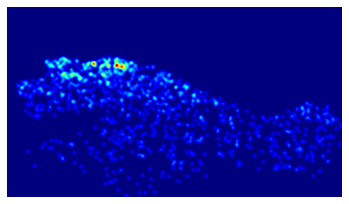

In [44]:
from matplotlib import pyplot as plt
pred_map = pred_map/np.max(pred_map+1e-20)

den = den/np.max(den+1e-20)


den_frame = plt.gca()
plt.imshow(den,cmap='jet')
den_frame.axes.get_yaxis().set_visible(False)
den_frame.axes.get_xaxis().set_visible(False)
den_frame.spines['top'].set_visible(False)
den_frame.spines['bottom'].set_visible(False)
den_frame.spines['left'].set_visible(False)
den_frame.spines['right'].set_visible(False)

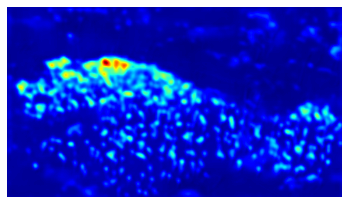

In [45]:
pred_frame = plt.gca()
plt.imshow(pred_map,cmap='jet')
pred_frame.axes.get_yaxis().set_visible(False)
pred_frame.axes.get_xaxis().set_visible(False)
pred_frame.spines['top'].set_visible(False)
pred_frame.spines['bottom'].set_visible(False)
pred_frame.spines['left'].set_visible(False)
pred_frame.spines['right'].set_visible(False)

In [24]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize

  Created wheel for gputil: filename=GPUtil-1.4.0-py3-none-any.whl size=7411 sha256=5db2bf0173e22956ecdd5f91aca2299047113d971879c91bfa10b976ee3d325d
  Stored in directory: /root/.cache/pip/wheels/6e/f8/83/534c52482d6da64622ddbf72cd93c35d2ef2881b78fd08ff0c
Successfully built gputil


In [33]:
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 12.3 GB  | Proc size: 3.1 GB
GPU RAM Free: 10096MB | Used: 1345MB | Util  12% | Total 11441MB


In [32]:
import torch, gc
#with torch.no_grad():
gc.collect()
torch.cuda.empty_cache()
torch.cuda.memory_summary(device=None, abbreviated=False)


'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |     775 MB |    6789 MB |    2040 GB |    2040 GB |\n|       from large pool |     743 MB |    6763 MB |    2038 GB |    2037 GB |\n|       from small pool |      32 MB |      38 MB |       2 GB |       2 GB |\n|---------------------------------------------------------------------------|\n| Active memory         |     775 MB |    6789 MB |    2040 GB |    2040 GB |\n|       from large pool |     743 MB |    6763 MB |